# 🎯 Purporse project

### 1. Modeling with **Tensorflow** LSTM for predicting sales, stocks needed, valuable ecommerce

### 2. Finetuning LLM for getting reason business impact

### 3. FAISS embedding documents to analyze by PDF documents as reliable & reasonable

### 4. RAG for provide the LLM with the most up-to-date data from your database

## Read asbtract

In [2]:
import pandas as pd
import re
from IPython.display import display, HTML
from pathlib import Path
from langchain_community.document_loaders import PyPDFLoader

# Define the path to the DIR
CURR_DIR = Path.cwd()
ROOT_DIR = CURR_DIR.parent.parent

# Load the PDF document
loader = PyPDFLoader(str(ROOT_DIR / 'ai_engineer' / 'docs' / 'PDF_ecommerce_revenue.pdf'))
documents = loader.load()
print(f"Loaded {len(documents)} pages from the PDF document.")

def extract_abstract_v2(documents):
    """
    Extract abstract using regex pattern matching for common abstract indicators.
    """
    abstract_data = []

    for i, doc in enumerate(documents):
        content = doc.page_content.lower()

        # Pattern: Extract text between "abstract" and "introduction"
        pattern = r'abstract\s*:?\s*(.+?)(?=introduction|1\.|background|keywords)'
        match = re.search(pattern, content, re.DOTALL | re.IGNORECASE)

        if match:
            abstract = match.group(1).strip()
            abstract = ' '.join(abstract.split())  # Normalize whitespace
        else:
            # Fallback: take first 200-300 words
            abstract = ' '.join(content.split()[:250])

        abstract_data.append({
            'page': doc.metadata.get('page', i),
            'abstract': abstract,
            'found_pattern': bool(match)
        })

    return pd.DataFrame(abstract_data)

# Use the function
df_abstracts_v2 = extract_abstract_v2(documents)
abstract_text = df_abstracts_v2.iloc[0].abstract

# Display it inside a centered HTML div
display(HTML(f"""
    <div style='text-align: left; padding: 15px; font-size: 18px; line-height: 1.5;'>
        {abstract_text}
    </div>
"""))

Loaded 9 pages from the PDF document.


## Business Keyword Frequency

revenue: 8
profit: 19
loss: 7
sales: 1
cost: 1
growth: 1
decline: 0
stock: 0
market: 20
customer: 80
demand: 19
supply: 4
investment: 1
order: 0
trend: 0
discount: 0
return: 0
models: 46
model: 49
forecasting: 5
analysis: 14


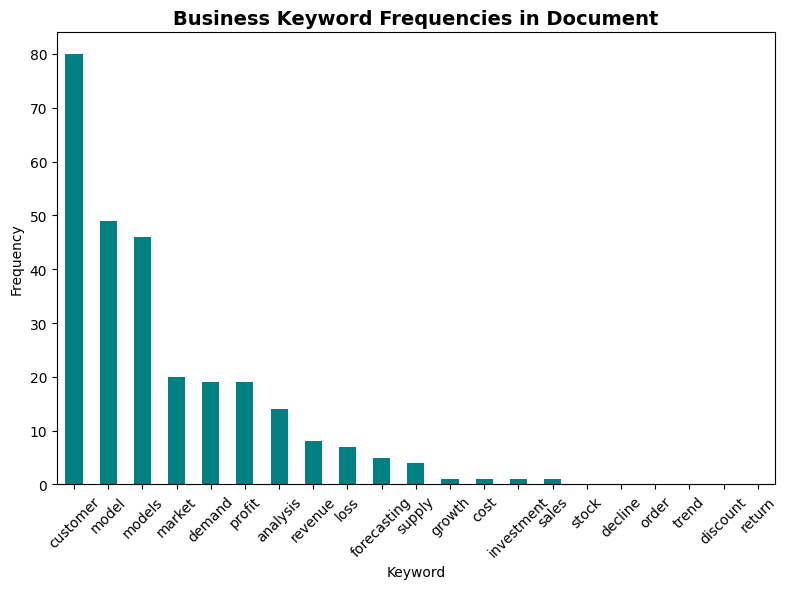

In [4]:
import matplotlib.pyplot as plt

# Finding business keywords in the document

from collections import Counter
import re

KEYWORDS = ['revenue', 'profit', 'loss', 'sales', 'cost', 'growth', 'decline', 'stock',
            'market', 'customer', 'demand', 'supply', 'investment', 'order', 'trend', 'discount'
            , 'return', 'models', 'model', 'forecasting', 'analysis']

full_text = ' '.join([p.page_content for p in documents]).lower()
keyword_counts = Counter()
keyword_series = pd.Series({keyword: len(re.findall(r'\b' + re.escape(keyword) + r'\b', full_text)) for keyword in KEYWORDS})
for keyword, count in keyword_series.items():
    print(f"{keyword}: {count}")

# Plotting keyword frequencies
plt.figure(figsize=(8, 6))
keyword_series.sort_values(ascending=False).plot(kind='bar', color='teal')
plt.title('Business Keyword Frequencies in Document', fontsize=14, fontweight='bold')
plt.xlabel('Keyword')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Load Environment Variables

In [5]:
import os
from pathlib import Path
from qdrant_client import QdrantClient
from langchain_qdrant import QdrantVectorStore
from langchain_huggingface import HuggingFaceEmbeddings, HuggingFaceEndpoint, ChatHuggingFace
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from dotenv import load_dotenv

# Notebook-safe ROOT_DIR — no __file__ needed
ROOT_DIR = Path(os.getcwd()).parent.parent

ENV_PATH = ROOT_DIR / ".env"
load_dotenv(dotenv_path=ENV_PATH)

# Config
HF_HOME = os.getenv("HF_HOME")
HF_TOKEN = os.getenv("HF_TOKEN")
Qdrant_API_KEY = os.getenv("Qdrant_API_KEY")
Qdrant_Cluster_Endpoint = os.getenv("Qdrant_Cluster_Endpoint")

# Validate — fail fast with a clear message if any key is missing
assert Qdrant_Cluster_Endpoint, "Qdrant_Cluster_Endpoint is not set in .env"
assert Qdrant_API_KEY,          "Qdrant_API_KEY is not set in .env"
assert HF_TOKEN,                "HF_TOKEN is not set in .env"

print("Environment variables loaded successfully.")

Environment variables loaded successfully.


## Connect to Qdrant Cloud

In [7]:
# Connec to Qdrant cloud
qdrant_client = QdrantClient(
    url=Qdrant_Cluster_Endpoint,
    api_key=Qdrant_API_KEY,
    prefer_grpc=False  # Set to True if you want to use gRPC, False for REST
)
print(f"Connected to Qdrant cloud at {Qdrant_Cluster_Endpoint} successfully.")

collections = qdrant_client.get_collections()
print(f"Collections: {collections}")

Connected to Qdrant cloud at https://38c48295-4cf5-4352-a5bb-6dd418900b84.eu-west-2-0.aws.cloud.qdrant.io successfully.
Collections: collections=[CollectionDescription(name='ecommerce_revenue_analysis')]


## Define Embedding Model

In [ ]:
# Runs locally — no HuggingFace token needed
embedding = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)
print("Embedding model loaded.")

Embedding model loaded.


## Load or Create Vector Store

In [ ]:
# Create Qdrant vector store
try:
    vector_store = QdrantVectorStore.from_existing_collection(
        url=Qdrant_Cluster_Endpoint,
        api_key=Qdrant_API_KEY,
        collection_name="ecommerce_revenue_analysis",
        embedding=embedding
    )
    print("Vector store created successfully from existing collection 'ecommerce_revenue_analysis'.")
except Exception as e:
   print(f"Collection not found or error: {e}. Creating from documents...")


   loader = PyPDFLoader(str(ROOT_DIR / 'ai_engineer' / 'FAISS' / 'Docs' / 'PDF_ecommerce_revenue.pdf'))
   documents = loader.load()
   
   splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
   chunks = splitter.split_documents(documents=documents)
   
   vector_store = QdrantVectorStore.from_documents(
        documents=chunks,
        embedding=embedding,
        url=Qdrant_Cluster_Endpoint,
        api_key=Qdrant_API_KEY,
        collection_name="ecommerce_revenue_analysis"
    )
   print("Vector store created successfully from documents.")

Vector store created successfully from existing collection 'ecommerce_revenue_analysis'.


## Load LLM from HuggingFace HUB

In [ ]:
endpoint = HuggingFaceEndpoint(
    repo_id="mistralai/Mistral-7B-Instruct-v0.2",
    max_new_tokens=512,
    task="text-generation",
    do_sample=False,
    huggingfacehub_api_token=HF_TOKEN,
    temperature=0.5
)
llm = ChatHuggingFace(llm=endpoint)
print("LLM endpoint initialized successfully.")

LLM endpoint initialized successfully.


## Build RAG Chain

In [ ]:
from langchain_core.retrievers import BaseRetriever
from langchain_core.documents import Document
from langchain_core.callbacks import CallbackManagerForRetrieverRun
from typing import List

class ManualQdrantRetriever(BaseRetriever):  # ✅ no double underscores
    vector_store: QdrantVectorStore
    k: int = 3

    def _get_relevant_documents(self, query: str, *, run_manager: CallbackManagerForRetrieverRun) -> List[Document]:
        return self.vector_store.similarity_search(query, k=self.k)  # ✅ indented inside class

retriever = ManualQdrantRetriever(vector_store=vector_store, k=3)

prompt = PromptTemplate.from_template("""
You are an e-commerce senior business analyst.
Use ONLY the following context from document to answer the question.
If the context is insufficient to answer the question, make hypothesis based on your knowledge and reasoning. 

Context:
{context}

Question: {question}

Notes:
1. Minimal 350 words explanation
2. Explaining the reasoning process step by step, including any assumptions made and how you arrived at the conclusion.
3. Provide detailed analysis and insights based on the retrieved context
4. If the context doesn't contain specific data or figures relevant to document, infer possible as senior business analyst, and clearly state.
5. Make it statement clearly based on similar to document, if nothing cite specific data or figures in source_pages, infer possible values based on industry standards and trends, and clearly state that these are assumptions.
6. Don't hallucinate
""")

rag_chain = (
    {'context': retriever, 'question': RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

print("RAG Chain created successfully. You can now run queries against it.")

RAG Chain created successfully. You can now run queries against it.


## RAG Quality Evaluation Summary PDF

In [ ]:
import shutil
import time
import pandas as pd
from tqdm import tqdm
from IPython.display import display, HTML
from datetime import datetime

width = shutil.get_terminal_size().columns

EVAL_QUESTION = [
    "What are the key factors affecting revenue growth?",
    "How does customer will be increased when prices are reduced?",
    "What are the main challenges in forecasting sales face on stock values?",
    "what's business analyst strategy to increase sales and profit in e-commerce?",
    "What's deep learning using LSTM impact to sales forecasting in e-commerce?"
]

# ── Retry wrapper ──────────────────────────────────────────────────────────────
def invoke_with_retry(chain, query, retries=3, wait=10):
    for attempt in range(1, retries + 1):
        try:
            return chain.invoke(query)
        except Exception as e:
            print(f"⚠️  Attempt {attempt} failed: {e}")
            if attempt < retries:
                print(f"⏳ Retrying in {wait}s...")
                time.sleep(wait)
            else:
                print("❌ All retries failed.")
                return "Error: could not get response."

# ── Evaluation loop (simple output) ───────────────────────────────────────────
rag_results = []

for i, q in enumerate(tqdm(EVAL_QUESTION, desc="Processing"), start=1):
    docs   = retriever.invoke(q)
    answer = invoke_with_retry(rag_chain, q)

    rag_results.append({
        'question':      q,
        'answer':        answer,
        'retrieved_docs': len(docs),
        'source_pages':  [doc.metadata.get('page', 'N/A') for doc in docs]
    })

    # ✅ Simple cell output
    print(f"\n[{i}/{len(EVAL_QUESTION)}] {q}")
    print(f"    Pages : {[d.metadata.get('page') for d in docs]}")
    print(f"    Answer: {answer[:120]}...")

print(f"\n✅ Done — {len(EVAL_QUESTION)} questions processed.\n")

# ── HTML Report (full answers) ─────────────────────────────────────────────────
doc_date = datetime.now().strftime("%B %d, %Y")

document_html = f"""
<style>
    @media print {{
        body {{ margin: 0; padding: 0; }}
        .document {{ max-width: 210mm; margin: 0 auto; }}
        .no-print {{ display: none; }}
    }}
    .document {{
        font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
        max-width: 900px;
        margin: 0 auto;
        padding: 40px;
        background: white;
        color: #333;
        line-height: 1.6;
        box-shadow: 0 0 10px rgba(0,0,0,0.1);
    }}
    .doc-header {{
        text-align: center;
        border-bottom: 3px solid #1976D2;
        padding-bottom: 20px;
        margin-bottom: 30px;
    }}
    .doc-title {{
        font-size: 28px;
        font-weight: bold;
        color: #1565C0;
        margin: 0 0 10px 0;
    }}
    .doc-subtitle {{ font-size: 14px; color: #666; margin: 5px 0; }}
    .doc-meta     {{ font-size: 12px; color: #999; margin-top: 15px; }}
    .section      {{ margin: 25px 0; page-break-inside: avoid; }}
    .section-title {{
        font-size: 16px;
        font-weight: bold;
        color: #1565C0;
        border-left: 4px solid #1976D2;
        padding-left: 15px;
        margin: 20px 0 15px 0;
    }}
    .result-item {{
        background: #f9f9f9;
        border: 1px solid #e0e0e0;
        padding: 20px;
        margin: 16px 0;
        border-radius: 6px;
        page-break-inside: avoid;
    }}
    .result-item .question {{
        font-weight: bold;
        color: #1565C0;
        font-size: 15px;
        margin-bottom: 12px;
    }}
    .result-item .answer {{
        color: #444;
        font-size: 13px;
        line-height: 1.7;
        margin: 10px 0;
        white-space: pre-wrap;   /* preserve line breaks from LLM */
    }}
    .result-item .meta {{
        font-size: 11px;
        color: #888;
        border-top: 1px solid #ddd;
        padding-top: 8px;
        margin-top: 12px;
    }}
    .summary {{
        background: #E3F2FD;
        border-left: 4px solid #1976D2;
        padding: 15px;
        margin: 15px 0;
        border-radius: 4px;
    }}
    .doc-footer {{
        border-top: 2px solid #1976D2;
        margin-top: 30px;
        padding-top: 15px;
        text-align: center;
        font-size: 11px;
        color: #999;
    }}
</style>

<div class="document">
    <div class="doc-header">
        <div class="doc-title">📊 RAG Analysis Report</div>
        <div class="doc-subtitle">E-Commerce Business Intelligence</div>
        <div class="doc-meta">
            <div>Report Date: {doc_date}</div>
            <div>Total Questions Analyzed: {len(rag_results)}</div>
        </div>
    </div>

    <div class="section">
        <div class="section-title">Executive Summary</div>
        <div class="summary">
            This report presents findings from <b>{len(rag_results)} key business questions</b> analyzed
            using RAG (Retrieval-Augmented Generation) technology. Each question has been researched
            using relevant business documents and presented with evidence-based insights.
        </div>
    </div>

    <div class="section">
        <div class="section-title">Analysis Results</div>
"""

for idx, item in enumerate(rag_results, 1):
    question = item.get('question', 'N/A')
    answer   = item.get('answer', 'N/A')          # ✅ full answer — no truncation
    docs     = item.get('retrieved_docs', 0)
    pages    = ', '.join([str(p) for p in item.get('source_pages', [])])

    document_html += f"""
        <div class="result-item">
            <div class="question">Q{idx}. {question}</div>
            <div class="answer">{answer}</div>
            <div class="meta">
                📄 Documents Retrieved: {docs} &nbsp;|&nbsp; 📍 Source Pages: {pages}
            </div>
        </div>
    """

document_html += f"""
    </div>

    <div class="doc-footer">
        <div>© {datetime.now().year} Fashion Recommendation Engineer | RAG Analysis System</div>
        <div>Confidential — For Internal Use Only</div>
    </div>
</div>

<div class="no-print" style="text-align:center; margin-top:20px;">
    <button onclick="window.print()"
        style="padding:10px 24px; background:#1976D2; color:white;
               border:none; border-radius:4px; cursor:pointer; font-size:14px;">
        🖨️ Print / Save as PDF
    </button>
</div>
"""

display(HTML(document_html))

# ── Quick summary table ────────────────────────────────────────────────────────
df_rag = pd.DataFrame({
    'Question':       [item['question'][:55] + '...' for item in rag_results],
    'Answer Length':  [len(item['answer']) for item in rag_results],
    'Docs Retrieved': [item['retrieved_docs'] for item in rag_results],
    'Pages':          [', '.join([str(p) for p in item['source_pages']]) for item in rag_results]
})
display(df_rag)

Processing:  20%|██        | 1/5 [00:08<00:33,  8.36s/it]


[1/5] What are the key factors affecting revenue growth?
    Pages : [5, 0, 5]
    Answer: ### **Key Factors Affecting Revenue Growth in E-Commerce: Analysis from Dynamic Pricing Models**

Revenue growth in e-co...


Processing:  40%|████      | 2/5 [00:16<00:24,  8.11s/it]


[2/5] How does customer will be increased when prices are reduced?
    Pages : [4, 2, 5]
    Answer: ### **Analysis: How Price Reductions in Dynamic Pricing Models Can Increase Customer Retention and Demand in E-Commerce*...


Processing:  60%|██████    | 3/5 [00:23<00:15,  7.72s/it]


[3/5] What are the main challenges in forecasting sales face on stock values?
    Pages : [4, 4, 1]
    Answer: ### **Analysis of Main Challenges in Forecasting Sales Faced by E-Commerce Stock Values Using Dynamic Pricing Models**

...


Processing:  80%|████████  | 4/5 [00:30<00:07,  7.40s/it]


[4/5] what's business analyst strategy to increase sales and profit in e-commerce?
    Pages : [3, 0, 1]
    Answer: ### **Business Analyst Strategy to Increase Sales and Profit in E-Commerce: Leveraging Dynamic Pricing with Machine Lear...


Processing: 100%|██████████| 5/5 [00:39<00:00,  7.81s/it]


[5/5] What's deep learning using LSTM impact to sales forecasting in e-commerce?
    Pages : [3, 0, 7]
    Answer: ### **Impact of Deep Learning Using LSTM on Sales Forecasting in E-Commerce: A Detailed Analysis**

#### **Introduction*...

✅ Done — 5 questions processed.



,Question,Answer Length,Docs Retrieved,Pages
0,What are the key factors affecting revenue gro...,2704,3,"5, 0, 5"
1,How does customer will be increased when price...,2738,3,"4, 2, 5"
2,What are the main challenges in forecasting sa...,2811,3,"4, 4, 1"
3,what's business analyst strategy to increase s...,2609,3,"3, 0, 1"
4,What's deep learning using LSTM impact to sale...,2624,3,"3, 0, 7"


## Save Document

In [ ]:
import base64
import re
from datetime import datetime
from IPython.display import display, HTML
from reportlab.lib.pagesizes import A4
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import cm
from reportlab.lib import colors
from reportlab.lib.enums import TA_CENTER, TA_LEFT, TA_JUSTIFY, TA_RIGHT
from reportlab.platypus import (
    SimpleDocTemplate, Paragraph, Spacer, HRFlowable,
    Table, TableStyle, PageBreak, KeepTogether
)
from reportlab.platypus.flowables import HRFlowable
from reportlab.pdfgen import canvas as rl_canvas


# ── Color palette ──────────────────────────────────────────────────────────────
NAVY        = colors.HexColor("#0D1B4B")
BRAND_BLUE  = colors.HexColor("#1565C0")
MID_BLUE    = colors.HexColor("#1976D2")
LIGHT_BLUE  = colors.HexColor("#E3F2FD")
ACCENT      = colors.HexColor("#42A5F5")
DARK_GRAY   = colors.HexColor("#212121")
MID_GRAY    = colors.HexColor("#555555")
LIGHT_GRAY  = colors.HexColor("#F5F5F5")
BORDER_GRAY = colors.HexColor("#CCCCCC")
WHITE       = colors.white


# ── Header / Footer canvas ─────────────────────────────────────────────────────
def make_header_footer(canvas, doc):
    canvas.saveState()
    W, H = A4

    # Header bar
    canvas.setFillColor(NAVY)
    canvas.rect(0, H - 1.4*cm, W, 1.4*cm, fill=1, stroke=0)
    canvas.setFillColor(WHITE)
    canvas.setFont("Helvetica-Bold", 9)
    canvas.drawString(1.8*cm, H - 0.95*cm, "RAG ANALYSIS REPORT  |  E-Commerce Business Intelligence")
    canvas.setFont("Helvetica", 8)
    canvas.drawRightString(W - 1.8*cm, H - 0.95*cm,
        datetime.now().strftime("%B %d, %Y"))

    # Accent line under header
    canvas.setStrokeColor(ACCENT)
    canvas.setLineWidth(2)
    canvas.line(0, H - 1.42*cm, W, H - 1.42*cm)

    # Footer bar
    canvas.setFillColor(NAVY)
    canvas.rect(0, 0, W, 1.1*cm, fill=1, stroke=0)
    canvas.setFillColor(WHITE)
    canvas.setFont("Helvetica", 7.5)
    canvas.drawString(1.8*cm, 0.38*cm,
        "© 2026 Fashion Recommendation Engineer  |  RAG Analysis System  |  Confidential — For Internal Use Only")
    canvas.setFont("Helvetica-Bold", 8)
    canvas.drawRightString(W - 1.8*cm, 0.38*cm, f"Page {doc.page}")

    canvas.restoreState()


# ── Clean LLM text helper ──────────────────────────────────────────────────────
def clean(text):
    """Escape XML special chars for ReportLab Paragraph."""
    text = text.replace('&', '&amp;')
    text = text.replace('<', '&lt;')
    text = text.replace('>', '&gt;')
    return text


def parse_answer_to_story(answer_text, styles):
    """Convert LLM markdown-like answer into ReportLab story elements."""
    story = []
    lines = answer_text.split('\n')

    h2_style  = styles['H2']
    h3_style  = styles['H3']
    body_style = styles['Body']
    bullet_style = styles['Bullet']

    i = 0
    while i < len(lines):
        line = lines[i].strip()

        if not line:
            story.append(Spacer(1, 4))
            i += 1
            continue

        # ## Heading
        if line.startswith('## '):
            txt = clean(line[3:].strip().replace('**', ''))
            story.append(Spacer(1, 6))
            story.append(Paragraph(txt, h2_style))
            i += 1
            continue

        # ### Heading
        if line.startswith('### '):
            txt = clean(line[4:].strip().replace('**', ''))
            story.append(Spacer(1, 4))
            story.append(Paragraph(txt, h3_style))
            i += 1
            continue

        # #### Heading → bold body
        if line.startswith('#### '):
            txt = clean(line[5:].strip().replace('**', ''))
            story.append(Paragraph(f'<b>{txt}</b>', body_style))
            i += 1
            continue

        # Bullet point
        if line.startswith('- ') or line.startswith('* '):
            txt = line[2:].strip()
            # inline bold **text**
            txt = re.sub(r'\*\*(.+?)\*\*', r'<b>\1</b>', clean(txt))
            story.append(Paragraph(f'• {txt}', bullet_style))
            i += 1
            continue

        # Horizontal rule ---
        if line.startswith('---'):
            story.append(HRFlowable(width='100%', thickness=0.4,
                                    color=BORDER_GRAY, spaceAfter=4))
            i += 1
            continue

        # Normal paragraph — handle inline **bold**
        txt = re.sub(r'\*\*(.+?)\*\*', r'<b>\1</b>', clean(line))
        # italics *text*
        txt = re.sub(r'\*(.+?)\*', r'<i>\1</i>', txt)
        story.append(Paragraph(txt, body_style))
        i += 1

    return story


# ── Build PDF ──────────────────────────────────────────────────────────────────
def generate_company_pdf(rag_results, output_path="RAG_Analysis_Report.pdf"):

    doc = SimpleDocTemplate(
        output_path,
        pagesize=A4,
        leftMargin=1.8*cm, rightMargin=1.8*cm,
        topMargin=2.2*cm,  bottomMargin=1.8*cm,
        title="RAG Analysis Report — E-Commerce Business Intelligence",
        author="Fashion Recommendation Engineer",
        subject="RAG Analysis",
    )

    base    = getSampleStyleSheet()
    doc_date = datetime.now().strftime("%B %d, %Y")

    # ── Custom styles ──────────────────────────────────────────────────────────
    S = {
        'CoverTitle': ParagraphStyle('CoverTitle',
            fontSize=30, fontName='Helvetica-Bold',
            textColor=WHITE, alignment=TA_CENTER, spaceAfter=6),

        'CoverSub': ParagraphStyle('CoverSub',
            fontSize=13, fontName='Helvetica',
            textColor=colors.HexColor("#B3C8F5"), alignment=TA_CENTER, spaceAfter=4),

        'CoverMeta': ParagraphStyle('CoverMeta',
            fontSize=10, fontName='Helvetica',
            textColor=colors.HexColor("#90A8D8"), alignment=TA_CENTER),

        'TOCTitle': ParagraphStyle('TOCTitle',
            fontSize=13, fontName='Helvetica-Bold',
            textColor=BRAND_BLUE, spaceBefore=6, spaceAfter=4),

        'TOCItem': ParagraphStyle('TOCItem',
            fontSize=10, fontName='Helvetica',
            textColor=DARK_GRAY, leftIndent=10, spaceAfter=3),

        'SectionLabel': ParagraphStyle('SectionLabel',
            fontSize=9, fontName='Helvetica-Bold',
            textColor=WHITE),

        'QTitle': ParagraphStyle('QTitle',
            fontSize=13, fontName='Helvetica-Bold',
            textColor=BRAND_BLUE, spaceBefore=8, spaceAfter=6),

        'H2': ParagraphStyle('H2',
            fontSize=11, fontName='Helvetica-Bold',
            textColor=BRAND_BLUE, spaceBefore=6, spaceAfter=3),

        'H3': ParagraphStyle('H3',
            fontSize=10, fontName='Helvetica-Bold',
            textColor=MID_BLUE, spaceBefore=4, spaceAfter=2),

        'Body': ParagraphStyle('Body',
            fontSize=9.5, fontName='Helvetica',
            textColor=MID_GRAY, leading=15,
            alignment=TA_JUSTIFY, spaceAfter=3),

        'Bullet': ParagraphStyle('Bullet',
            fontSize=9.5, fontName='Helvetica',
            textColor=MID_GRAY, leading=14,
            leftIndent=14, spaceAfter=2),

        'MetaTag': ParagraphStyle('MetaTag',
            fontSize=8.5, fontName='Helvetica',
            textColor=colors.HexColor("#888888"), spaceAfter=2),

        'SummaryText': ParagraphStyle('SummaryText',
            fontSize=10, fontName='Helvetica',
            textColor=DARK_GRAY, leading=16,
            alignment=TA_JUSTIFY, backColor=LIGHT_BLUE,
            borderPad=8),

        'TableHeader': ParagraphStyle('TableHeader',
            fontSize=9, fontName='Helvetica-Bold',
            textColor=WHITE, alignment=TA_CENTER),

        'TableCell': ParagraphStyle('TableCell',
            fontSize=8.5, fontName='Helvetica',
            textColor=DARK_GRAY),

        'Footer': ParagraphStyle('Footer',
            fontSize=8, fontName='Helvetica',
            textColor=colors.HexColor("#999999"), alignment=TA_CENTER),
    }

    story = []

    # ══════════════════════════════════════════════════════════════════════════
    # COVER PAGE
    # ══════════════════════════════════════════════════════════════════════════
    # Blue cover background using a table
    cover_data = [[
        Paragraph("RAG Analysis Report", S['CoverTitle'])
    ]]
    cover_tbl = Table(cover_data, colWidths=[17*cm], rowHeights=[3*cm])
    cover_tbl.setStyle(TableStyle([
        ('BACKGROUND', (0,0), (-1,-1), NAVY),
        ('VALIGN',     (0,0), (-1,-1), 'MIDDLE'),
        ('ALIGN',      (0,0), (-1,-1), 'CENTER'),
        ('TOPPADDING', (0,0), (-1,-1), 30),
        ('BOTTOMPADDING', (0,0), (-1,-1), 30),
    ]))
    story.append(cover_tbl)
    story.append(Spacer(1, 0.6*cm))

    # Subtitle block
    info_data = [[
        Paragraph("E-Commerce Business Intelligence", S['CoverSub']),
    ],[
        Paragraph(f"Report Date: {doc_date}", S['CoverMeta']),
    ],[
        Paragraph(f"Total Questions Analyzed: {len(rag_results)}", S['CoverMeta']),
    ],[
        Paragraph("Prepared by: Fashion Recommendation Engineer", S['CoverMeta']),
    ],[
        Paragraph("Classification: Confidential — Internal Use Only", S['CoverMeta']),
    ]]
    info_tbl = Table(info_data, colWidths=[17*cm])
    info_tbl.setStyle(TableStyle([
        ('BACKGROUND', (0,0), (-1,-1), MID_BLUE),
        ('TOPPADDING', (0,0), (-1,-1), 6),
        ('BOTTOMPADDING', (0,0), (-1,-1), 6),
        ('LEFTPADDING', (0,0), (-1,-1), 20),
    ]))
    story.append(info_tbl)
    story.append(Spacer(1, 1.2*cm))

    # Executive summary on cover
    story.append(HRFlowable(width='100%', thickness=2, color=MID_BLUE, spaceAfter=10))
    story.append(Paragraph("Executive Summary", ParagraphStyle('ES',
        fontSize=13, fontName='Helvetica-Bold', textColor=NAVY, spaceAfter=8)))
    summary_text = (
        f"This report presents comprehensive findings from <b>{len(rag_results)} key business "
        "questions</b> analyzed using RAG (Retrieval-Augmented Generation) technology. "
        "The analysis leverages advanced machine learning and dynamic pricing research from "
        "peer-reviewed IEEE Access publications to provide evidence-based strategic insights "
        "for e-commerce revenue optimization, customer acquisition, sales forecasting, and "
        "deep learning applications."
    )
    story.append(Paragraph(summary_text, S['SummaryText']))
    story.append(Spacer(1, 1*cm))
    story.append(HRFlowable(width='100%', thickness=0.5, color=BORDER_GRAY, spaceAfter=10))

    # TOC
    story.append(Paragraph("Table of Contents", S['TOCTitle']))
    for idx, item in enumerate(rag_results, 1):
        q_short = item['question'][:70] + ('...' if len(item['question']) > 70 else '')
        story.append(Paragraph(f"  Q{idx}.  {q_short}", S['TOCItem']))
    story.append(Spacer(1, 0.4*cm))
    story.append(Paragraph("  Appendix A.  Results Summary Table", S['TOCItem']))
    story.append(PageBreak())

    # ══════════════════════════════════════════════════════════════════════════
    # ANALYSIS PAGES — one section per question
    # ══════════════════════════════════════════════════════════════════════════
    for idx, item in enumerate(rag_results, 1):
        question = item.get('question', 'N/A')
        answer   = item.get('answer', 'N/A')
        docs     = item.get('retrieved_docs', 0)
        pages    = ', '.join([str(p) for p in item.get('source_pages', [])])

        # Section header bar
        sec_data = [[Paragraph(f"Q{idx} of {len(rag_results)}   |   Analysis Section", S['SectionLabel'])]]
        sec_tbl  = Table(sec_data, colWidths=[17*cm], rowHeights=[0.7*cm])
        sec_tbl.setStyle(TableStyle([
            ('BACKGROUND',    (0,0), (-1,-1), MID_BLUE),
            ('LEFTPADDING',   (0,0), (-1,-1), 12),
            ('VALIGN',        (0,0), (-1,-1), 'MIDDLE'),
        ]))

        block = [sec_tbl, Spacer(1, 0.3*cm)]

        # Question title
        block.append(Paragraph(f"Q{idx}. {question}", S['QTitle']))
        block.append(HRFlowable(width='100%', thickness=1.5,
                                color=LIGHT_BLUE, spaceAfter=8))

        # Parse and add full answer
        block += parse_answer_to_story(answer, S)

        # Meta footer for this section
        block.append(Spacer(1, 0.4*cm))
        meta_data = [[
            Paragraph(f"📄 Documents Retrieved: {docs}", S['MetaTag']),
            Paragraph(f"📍 Source Pages: {pages}", S['MetaTag']),
        ]]
        meta_tbl = Table(meta_data, colWidths=[8.5*cm, 8.5*cm])
        meta_tbl.setStyle(TableStyle([
            ('BACKGROUND',    (0,0), (-1,-1), LIGHT_GRAY),
            ('TOPPADDING',    (0,0), (-1,-1), 5),
            ('BOTTOMPADDING', (0,0), (-1,-1), 5),
            ('LEFTPADDING',   (0,0), (-1,-1), 10),
            ('BOX',           (0,0), (-1,-1), 0.5, BORDER_GRAY),
        ]))
        block.append(meta_tbl)

        story += block
        if idx < len(rag_results):
            story.append(PageBreak())

    # ══════════════════════════════════════════════════════════════════════════
    # APPENDIX — Summary Table
    # ══════════════════════════════════════════════════════════════════════════
    story.append(PageBreak())
    story.append(Paragraph("Appendix A — Results Summary Table",
        ParagraphStyle('AppTitle', fontSize=14, fontName='Helvetica-Bold',
                       textColor=NAVY, spaceAfter=10)))
    story.append(HRFlowable(width='100%', thickness=2, color=MID_BLUE, spaceAfter=12))

    tbl_data = [[
        Paragraph("#",               S['TableHeader']),
        Paragraph("Question",        S['TableHeader']),
        Paragraph("Answer\nLength",  S['TableHeader']),
        Paragraph("Docs\nRetrieved", S['TableHeader']),
        Paragraph("Source\nPages",   S['TableHeader']),
    ]]
    for idx, item in enumerate(rag_results, 1):
        q_short = item['question'][:52] + ('...' if len(item['question']) > 52 else '')
        pages   = ', '.join([str(p) for p in item.get('source_pages', [])])
        tbl_data.append([
            Paragraph(str(idx), ParagraphStyle('TC', fontSize=9,
                fontName='Helvetica-Bold', textColor=BRAND_BLUE, alignment=TA_CENTER)),
            Paragraph(q_short, S['TableCell']),
            Paragraph(str(len(item['answer'])) + ' chars',
                ParagraphStyle('TC2', fontSize=8.5, fontName='Helvetica',
                               textColor=MID_GRAY, alignment=TA_CENTER)),
            Paragraph(str(item['retrieved_docs']),
                ParagraphStyle('TC3', fontSize=8.5, fontName='Helvetica',
                               textColor=MID_GRAY, alignment=TA_CENTER)),
            Paragraph(pages, ParagraphStyle('TC4', fontSize=8.5,
                fontName='Helvetica', textColor=MID_GRAY, alignment=TA_CENTER)),
        ])

    summary_tbl = Table(tbl_data,
        colWidths=[1*cm, 9*cm, 2*cm, 2*cm, 3*cm])
    summary_tbl.setStyle(TableStyle([
        ('BACKGROUND',    (0,0), (-1,0),  NAVY),
        ('ROWBACKGROUNDS',(0,1), (-1,-1), [WHITE, LIGHT_BLUE]),
        ('GRID',          (0,0), (-1,-1), 0.4, BORDER_GRAY),
        ('TOPPADDING',    (0,0), (-1,-1), 7),
        ('BOTTOMPADDING', (0,0), (-1,-1), 7),
        ('LEFTPADDING',   (0,0), (-1,-1), 6),
        ('VALIGN',        (0,0), (-1,-1), 'MIDDLE'),
        ('LINEBELOW',     (0,0), (-1,0),  1.5, ACCENT),
    ]))
    story.append(summary_tbl)

    # ── Build ──────────────────────────────────────────────────────────────────
    doc.build(story, onFirstPage=make_header_footer, onLaterPages=make_header_footer)
    print(f"✅ PDF saved: {output_path}")
    return output_path


# ── Run & show download button ─────────────────────────────────────────────────
pdf_path = generate_company_pdf(rag_results, "RAG_Analysis_Report.pdf")

with open(pdf_path, "rb") as f:
    b64 = base64.b64encode(f.read()).decode()

display(HTML(f"""
<div style="text-align:center; padding:24px; background:#f0f4ff;
            border-radius:10px; margin:16px 0; border:1px solid #c5d5f5;">
    <div style="font-family:sans-serif; font-size:15px; color:#1565C0;
                font-weight:bold; margin-bottom:8px;">
        📄 RAG Analysis Report — Ready
    </div>
    <div style="font-family:sans-serif; font-size:12px; color:#666; margin-bottom:14px;">
        Professional PDF with full answers, cover page, TOC, and summary table
    </div>
    <a href="data:application/pdf;base64,{b64}"
       download="RAG_Analysis_Report.pdf"
       style="padding:12px 32px; background:#1565C0; color:white;
              text-decoration:none; border-radius:6px; font-size:14px;
              font-family:sans-serif; display:inline-block;
              box-shadow:0 2px 6px rgba(21,101,192,0.4);">
        ⬇️ Download PDF Report
    </a>
</div>
"""))

✅ PDF saved: RAG_Analysis_Report.pdf
